<a href="https://colab.research.google.com/github/NirajBagh/Health-Monitoring-of-Industrial-Machines-Using-Change-Detection/blob/main/Change_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change detection in industrial machine using NannyML

Change detection in industrial machines is crucial for several reasons, primarily to ensure the efficient operation, reliability, and safety of the equipment.Change detection helps in identifying abnormal patterns or deviations in machine behavior (e.g., vibration, temperature, or power consumption). Early detection allows operators to perform preventive maintenance, reducing downtime and preventing catastrophic failures.
Continuous monitoring and detecting changes in machine performance can signal when machinery is not operating at optimal efficiency. Adjustments can then be made to improve performance, saving energy and resources.
 Early detection of changes in machine performance ensures that corrective actions are taken before a machine failure occurs, minimizing production interruptions.

This notebook is intended to illustrate the change detection of industrial machinery by walking through a real life dataset of bearing vibration data.

# The Dataset

The dataset is sourced from the NASA repo https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/.

Dataset Citation : J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA

The Nasa data set describes a test-to-failure experiment. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point.

In [1]:
# Common imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Machine life detection/2nd_test'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs], ignore_index=False)

# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [4]:
# Check - Begining of Data
merged_data.head()

Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004-02-12 10:32:39   0.058333   0.071832   0.083242   0.043067
2004-02-12 10:42:39   0.058995   0.074006   0.084435   0.044541
2004-02-12 10:52:39   0.060236   0.074227   0.083926   0.044443
2004-02-12 11:02:39   0.061455   0.073844   0.084457   0.045081
2004-02-12 11:12:39   0.061361   0.075609   0.082837   0.045118

In [5]:
# Check - End of Data
merged_data.tail()

Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004-02-19 05:42:39   0.453335   0.161016   0.137440   0.119047
2004-02-19 05:52:39   0.337583   0.132400   0.144992   0.092125
2004-02-19 06:02:39   0.351111   0.152266   0.151299   0.100817
2004-02-19 06:12:39   0.001857   0.003732   0.003656   0.001786
2004-02-19 06:22:39   0.001168   0.000767   0.000716   0.001699

In [6]:
#Check Total Points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 985


# Visualization of data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

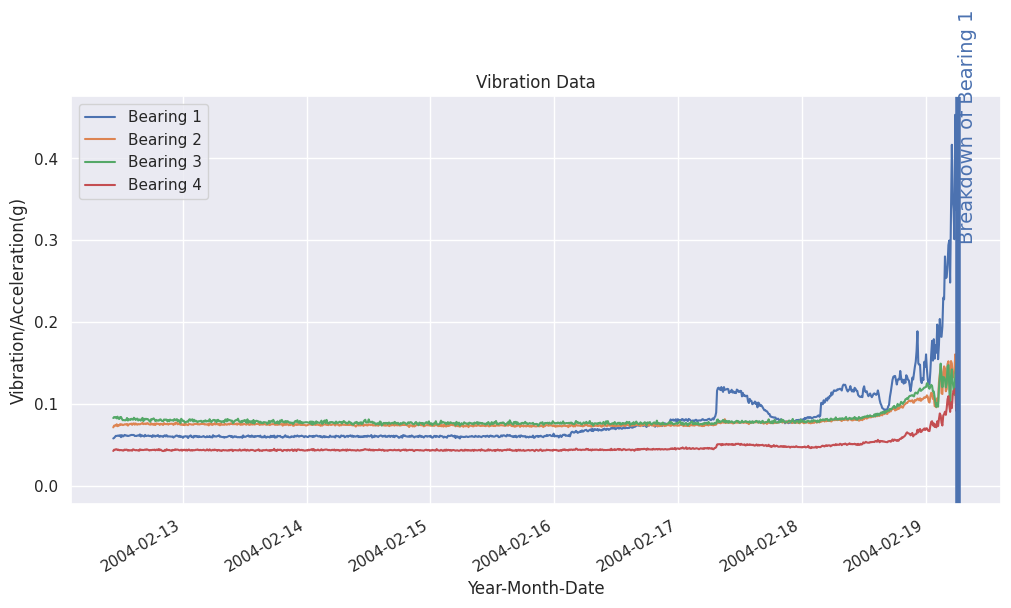

In [7]:
# Visualising Data
ax = merged_data.plot(figsize = (12,6), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=4, color='b', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

# Change detection using NannyML

NannyML is an open-source python library for estimating post-deployment model performance (without access to targets), detecting data drift, and intelligently link data drift alerts back to changes in model performance. Built for data scientists, NannyML has an easy-to-use interface, interactive visualizations, is completely model-agnostic and currently supports all tabular use cases, classification and regression.

In [8]:
!pip install NannyML

INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.0/23.0 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 42.7 MB/s e

# Create Referenace and Analysis Period

In [9]:
data=pd.read_csv("/content/merged_dataset_BearingTest_2.csv")

In [10]:
data.head()

Unnamed: 0  Bearing 1  Bearing 2  Bearing 3  Bearing 4
0  2004-02-12 10:32:39   0.058333   0.071832   0.083242   0.043067
1  2004-02-12 10:42:39   0.058995   0.074006   0.084435   0.044541
2  2004-02-12 10:52:39   0.060236   0.074227   0.083926   0.044443
3  2004-02-12 11:02:39   0.061455   0.073844   0.084457   0.045081
4  2004-02-12 11:12:39   0.061361   0.075609   0.082837   0.045118

In [11]:
data['timestamp']=data['Unnamed: 0']

In [12]:
# Dropping a column
data=data.drop(columns=['Unnamed: 0'])

In [13]:
reference_df1=data.iloc[0:100,:] # consider 1st 100 samples
analysis_df1=data.iloc[100:,:]

# Apply Univariate Drift Analysis

In [14]:
import nannyml as nml
from IPython.display import display
column_names = ['Bearing 1', 'Bearing 2','Bearing 2','Bearing 3']
calc = nml.UnivariateDriftCalculator(
column_names=column_names,
treat_as_categorical=['y_pred'],
timestamp_column_name='timestamp',
chunk_size=1,
continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
)



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [15]:
calc.fit(reference_df1)
results = calc.calculate(analysis_df1)
display(results.filter(period='reference', column_names=['Bearing 1']).to_df())

chunk                                                        \
      chunk                                                         
        key chunk_index start_index end_index          start_date   
0     [0:0]           0           0         0 2004-02-12 10:32:39   
1     [1:1]           1           1         1 2004-02-12 10:42:39   
2     [2:2]           2           2         2 2004-02-12 10:52:39   
3     [3:3]           3           3         3 2004-02-12 11:02:39   
4     [4:4]           4           4         4 2004-02-12 11:12:39   
..      ...         ...         ...       ...                 ...   
95  [95:95]          95          95        95 2004-02-13 02:22:39   
96  [96:96]          96          96        96 2004-02-13 02:32:39   
97  [97:97]          97          97        97 2004-02-13 02:42:39   
98  [98:98]          98          98        98 2004-02-13 02:52:39   
99  [99:99]          99          99        99 2004-02-13 03:02:39   

                                           Bearing 1                  \
                                  kolmogorov_smirnov                   
              end_date     period              value upper_threshold   
0  2004-02-12 10:32:39  reference               0.99               1   
1  2004-02-12 10:42:39  reference               0.97               1   
2  2004-02-12 10:52:39  reference               0.87               1   
3  2004-02-12 11:02:39  reference               0.58               1   
4  2004-02-12 11:12:39  reference               0.54               1   
..                 ...        ...                ...             ...   
95 2004-02-13 02:22:39  reference               0.72               1   
96 2004-02-13 02:32:39  reference               0.61               1   
97 2004-02-13 02:42:39  reference               0.85               1   
98 2004-02-13 02:52:39  reference               0.56               1   
99 2004-02-13 03:02:39  reference               0.93               1   

                                                                          \
                          jensen_shannon                                   
   lower_threshold  alert          value upper_threshold lower_threshold   
0             None  False       0.979557        0.993029            None   
1             None  False       0.949818        0.993029            None   
2             None  False       0.901943        0.993029            None   
3             None  False       0.756632        0.993029            None   
4             None  False       0.756632        0.993029            None   
..             ...    ...            ...             ...             ...   
95            None  False       0.781016        0.993029            None   
96            None  False       0.756632        0.993029            None   
97            None  False       0.781016        0.993029            None   
98            None  False       0.789344        0.993029            None   
99            None  False       0.901943        0.993029            None   

           
           
    alert  
0   False  
1   False  
2   False  
3   False  
4   False  
..    ...  
95  False  
96  False  
97  False  
98  False  
99  False  

[100 rows x 15 columns]

In [16]:
display(results.filter(period='analysis', column_names=['Bearing 1']).to_df(multilevel=False))

chunk_key  chunk_index  chunk_start_index  chunk_end_index  \
0        [0:0]            0                  0                0   
1        [1:1]            1                  1                1   
2        [2:2]            2                  2                2   
3        [3:3]            3                  3                3   
4        [4:4]            4                  4                4   
..         ...          ...                ...              ...   
879  [879:879]          879                879              879   
880  [880:880]          880                880              880   
881  [881:881]          881                881              881   
882  [882:882]          882                882              882   
883  [883:883]          883                883              883   

       chunk_start_date      chunk_end_date chunk_period  \
0   2004-02-13 03:12:39 2004-02-13 03:12:39     analysis   
1   2004-02-13 03:22:39 2004-02-13 03:22:39     analysis   
2   2004-02-13 03:32:39 2004-02-13 03:32:39     analysis   
3   2004-02-13 03:42:39 2004-02-13 03:42:39     analysis   
4   2004-02-13 03:52:39 2004-02-13 03:52:39     analysis   
..                  ...                 ...          ...   
879 2004-02-19 05:42:39 2004-02-19 05:42:39     analysis   
880 2004-02-19 05:52:39 2004-02-19 05:52:39     analysis   
881 2004-02-19 06:02:39 2004-02-19 06:02:39     analysis   
882 2004-02-19 06:12:39 2004-02-19 06:12:39     analysis   
883 2004-02-19 06:22:39 2004-02-19 06:22:39     analysis   

     Bearing 1_kolmogorov_smirnov_value  \
0                                  0.55   
1                                  0.86   
2                                  0.89   
3                                  0.87   
4                                  0.75   
..                                  ...   
879                                1.00   
880                                1.00   
881                                1.00   
882                                1.00   
883                                1.00   

     Bearing 1_kolmogorov_smirnov_upper_threshold  \
0                                               1   
1                                               1   
2                                               1   
3                                               1   
4                                               1   
..                                            ...   
879                                             1   
880                                             1   
881                                             1   
882                                             1   
883                                             1   

    Bearing 1_kolmogorov_smirnov_lower_threshold  \
0                                           None   
1                                           None   
2                                           None   
3                                           None   
4                                           None   
..                                           ...   
879                                         None   
880                                         None   
881                                         None   
882                                         None   
883                                         None   

     Bearing 1_kolmogorov_smirnov_alert  Bearing 1_jensen_shannon_value  \
0                                 False                        0.789344   
1                                 False                        0.781016   
2                                 False                        0.901943   
3                                 False                        0.901943   
4                                 False                        0.781016   
..                                  ...                             ...   
879                               False                        1.000000   
880                               False                        1.000000   
881                      

# Plot Change Detection in Bearing-1, Bearing-2, Bearing-3 and Bearing-4

In [17]:
figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
figure.show()

It is noted that the change detection was properly identified in Bearing-1 fault, and therefore, statistical properties were calculated for Bearing-1 for both univariate and multivariate change detection

# Calculate Statistical Properies for Bearing-1 Fault for Univariate and Multivariate Change Detection

In [18]:
def compute_skewness(x):
    n = len(x)
    third_moment = np.sum((x - np.mean(x))**3) / n
    s_3 = np.std(x, ddof = 1) ** 3
    return third_moment/s_3

In [19]:
def compute_kurtosis(x):
    n = len(x)
    fourth_moment = np.sum((x - np.mean(x))**4) / n
    s_4 = np.std(x, ddof = 1) ** 4
    return fourth_moment / s_4 - 3

In [20]:
# Initialize an empty DataFrame
Time_feature_matrix = pd.DataFrame()
test_set = 2
bearing_no = 1  # Provide the Bearing number [1,2,3,4] of the Test set
path = r'/content/drive/MyDrive/Machine life detection/2nd_test'

for filename in os.listdir(path):
    dataset = pd.read_csv(os.path.join(path, filename), sep='\t', header=None)
    bearing_data = np.array(dataset.iloc[:, bearing_no - 1])

    # Create a feature matrix
    feature_matrix = np.zeros((1, 9))
    temp = bearing_data
    feature_matrix[0, 0] = np.max(temp)
    feature_matrix[0, 1] = np.min(temp)
    feature_matrix[0, 2] = np.mean(temp)
    feature_matrix[0, 3] = np.std(temp, ddof=1)
    feature_matrix[0, 4] = np.sqrt(np.mean(temp ** 2))
    feature_matrix[0, 5] = compute_skewness(temp)  # Assuming this is a valid function
    feature_matrix[0, 6] = compute_kurtosis(temp)  # Assuming this is a valid function
    feature_matrix[0, 7] = feature_matrix[0, 0] / feature_matrix[0, 4]
    feature_matrix[0, 8] = feature_matrix[0, 4] / feature_matrix[0, 2]

    # Create a DataFrame for the current file
    df = pd.DataFrame(feature_matrix)
    df.index = [filename[:-3]]  # Set index based on filename

    # Use pd.concat to concatenate the DataFrames
    Time_feature_matrix = pd.concat([Time_feature_matrix, df])

# Display the resulting DataFrame
print(Time_feature_matrix)

                      0      1         2         3         4         5  \
2004.02.12.12.52  0.422 -0.383 -0.002372  0.079183  0.079217  0.024886   
2004.02.12.11.02  0.608 -0.576 -0.002277  0.078693  0.078724  0.041483   
2004.02.12.12.02  0.378 -0.344 -0.002097  0.075690  0.075718  0.046318   
2004.02.12.15.12  0.391 -0.344 -0.002356  0.078246  0.078280  0.033694   
2004.02.12.15.52  0.388 -0.344 -0.001880  0.077400  0.077421 -0.018265   
...                 ...    ...       ...       ...       ...       ...   
2004.02.19.03.32  1.162 -1.030 -0.001957  0.291652  0.291651 -0.027165   
2004.02.19.01.42  0.725 -0.862 -0.001916  0.202984  0.202988 -0.220118   
2004.02.19.05.02  4.998 -5.000  0.003389  0.672145  0.672137 -0.766011   
2004.02.19.03.52  1.086 -1.025 -0.001933  0.314813  0.314811  0.007877   
2004.02.19.06.02  3.501 -3.696 -0.001703  0.483844  0.483835 -0.377068   

                          6         7           8  
2004.02.12.12.52   0.550764  5.327141  -33.397776  
2004.02

In [21]:
Time_feature_matrix
Time_feature_matrix.columns = ['Max','Min','Mean','Std','RMS','Skewness','Kurtosis','Crest Factor','Form Factor']
Time_feature_matrix.index = pd.to_datetime(Time_feature_matrix.index, format='%Y.%m.%d.%H.%M')

Time_feature_matrix = Time_feature_matrix.sort_index()

Time_feature_matrix.to_csv('Time_feature_matrix_Bearing_{}_Test_{}.csv'.format(bearing_no,test_set))

Time_feature_matrix

Max    Min      Mean       Std       RMS  Skewness  \
2004-02-12 10:32:00  0.454 -0.386 -0.010196  0.073477  0.074179  0.083987   
2004-02-12 10:42:00  0.369 -0.388 -0.002585  0.075340  0.075382  0.052138   
2004-02-12 10:52:00  0.503 -0.400 -0.002484  0.076191  0.076230  0.032806   
2004-02-12 11:02:00  0.608 -0.576 -0.002277  0.078693  0.078724  0.041483   
2004-02-12 11:12:00  0.391 -0.391 -0.002404  0.078439  0.078474  0.028222   
...                    ...    ...       ...       ...       ...       ...   
2004-02-19 05:42:00  4.998 -5.000 -0.002752  0.725014  0.725001 -0.510519   
2004-02-19 05:52:00  2.688 -2.881 -0.004487  0.462001  0.462012 -0.325344   
2004-02-19 06:02:00  3.501 -3.696 -0.001703  0.483844  0.483835 -0.377068   
2004-02-19 06:12:00  0.005  0.000  0.001857  0.000987  0.002103  0.579656   
2004-02-19 06:22:00  0.002 -0.005 -0.001162  0.001000  0.001533  0.317009   

                      Kurtosis  Crest Factor  Form Factor  
2004-02-12 10:32:00   0.628408      6.120331    -7.275307  
2004-02-12 10:42:00   0.647935      4.895038   -29.161382  
2004-02-12 10:52:00   0.513132      6.598472   -30.688508  
2004-02-12 11:02:00   1.157547      7.723217   -34.579322  
2004-02-12 11:12:00   0.602825      4.982524   -32.645152  
...                        ...           ...          ...  
2004-02-19 05:42:00  12.576183      6.893779  -263.426419  
2004-02-19 05:52:00   3.759312      5.818035  -102.977656  
2004-02-19 06:02:00   4.890985      7.235932  -284.094983  
2004-02-19 06:12:00   3.636864      2.377543     1.132578  
2004-02-19 06:22:00  -1.609910      1.304860    -1.319089  

[984 rows x 9 columns]

# Create Referenace and Analysis Period

In [22]:
reference_df2=Time_feature_matrix.iloc[0:100,:]
analysis_df2=Time_feature_matrix.iloc[100:,:]

# Univariate Drift Detection

NannyML’s univariate approach for data drift looks at each variable individually and compares the chunks created from the analysis data period with the reference period. You can read more about periods and other data requirements in our section on data periods.

The comparison results in a single number, a drift metric, representing the amount of drift between the reference and analysis chunks. NannyML calculates them for every chunk, allowing you to track them over time.

In [23]:
import nannyml as nml
from IPython.display import display
column_names = ['Max', 'Min', 'Mean', 'Std', 'RMS', 'Skewness', 'Kurtosis',
       'Crest Factor', 'Form Factor']
calc = nml.UnivariateDriftCalculator(
column_names=column_names,
treat_as_categorical=['y_pred'],
timestamp_column_name='',         #timestamp
chunk_size=1,
continuous_methods=['kolmogorov_smirnov', 'jensen_shannon'],
)



In [24]:
calc.fit(reference_df2)
results = calc.calculate(analysis_df2)

# Plot Change Detection for all features

In [25]:
figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
figure.show()

The Univariate Drift Detection tutorial describes how NannyML analyzes each feature individually, and observes whether there are changes in the resulting feature distributions over time.

However, this is not enough to capture all the changes that may affect the model. The changes in correlations and more complex changes in relationships between model inputs might have a significant impact on model performance without changing univariate distributions of features. For example, the change detection found in features skewness and kurtosis and not in other features.

# Multivariate Drift Detection

Multivariate data drift detection compliments univariate data drift detection methods. It provides one summary number reducing the risk of false alerts, and detects more subtle changes in the data structure that cannot be detected with univariate approaches. The trade off is that multivariate drift results are less explainable compared to univariate drift results.

This method is able to capture complex changes in our data. The algorithm implementing Data Reconstruction with PCA works in three steps as described below.

The first step is data preparation. This includes missing values Imputation, frequency encoding, and scaling the data. Missing values need to be imputed because it is a PCA requirement. Frequency encoding is used to convert all categorical features into numbers. The next thing to do is standardize all features to 0 mean and unit variance, to make sure that all features contribute to PCA on equal footing.

The second step is the dimensionality reduction where PCA comes in. By default it aims to capture 65% of the dataset’s variance, but this is a parameter that can be changed. The PCA algorithm is fitted on the reference dataset and learns a transformation from the pre-processed model input space to a latent space.

NannyML then applies this transformation to compress the data that is being analyzed. It is important to note that the PCA method captures the internal structure of the model input data and ignores any random noise that is usually present.

The third step is decompressing the data we just compressed. This is done using the inverse PCA transformation which transforms the data from latent space back to the preprocessed model input space.

Then, the euclidean distance between the original data points and their re-constructed counterparts is computed. The resulting distances are then aggregated to get their average. The resulting number is called Reconstruction Error.

In [26]:
calc = nml.DataReconstructionDriftCalculator(
    column_names=column_names,
    timestamp_column_name='',  #timestamp
    chunk_size=1
)
calc.fit(reference_df2)
results = calc.calculate(analysis_df2)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning

# Plot Change Detection using multivariate Analysis

In [27]:
figure = results.plot()
figure.show()

The change in the features is now clearly visible through the change in the reconstruction error, while our earlier univariate approach detected no change.

# Conclusion

With change detection data, machine learning models can predict future failures or performance drops. This leads to more informed decision-making on equipment usage, maintenance schedules, and even the procurement of new machines. So, the change detection helps optimize industrial machine operations, reduce costs, ensure safety, and increase equipment reliability and lifespan, making it a critical component of modern industrial systems.